In [2]:
#Headers
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.cluster import KMeans
import sys
import os
from IPython.display import Image
import itertools
from sklearn import mixture
from scipy import linalg
import matplotlib
import imageio as io
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
#Include your other headers here

## Mixture of Gaussian, EM-Algorithm

### Apply EM algorithm to fit a mixture of gaussian distribution to the following datasets:

- Follow the technical advises given in the lecture, namely run first k-means for the first 10-100 iterations (if required for the built in function its takes care by itself)
- Check if you need to add regularisation 
- Plot 
    1. Initial distribution - All the points should have same color.
    2. Soft assignment -  Assign the data points to the particular cluster only if their probability is above 0.9 others are to be considered as outliers. So give different color for all the outliers and clusters as shown in the second plot of the image (You should explore the way to do this).
    3. Hard assignment -  Each cluster should have different colors here you won't have outliers since the neighbouring datapoints are assigned to some clusters.
   
- All the clusters should have ellipsoids of three standard deviation.
**Use sklearn**

In [3]:
#Dataset 1
np.random.seed(150)
means = np.array([[2.1, 4.5],
                  [2.0, 2.7],
                  [3.5, 5.6]])
covariances = [np.array([[0.20, 0.10], [0.10, 0.60]]),
               np.array([[0.35, 0.22], [0.22, 0.15]]),
               np.array([[0.06, 0.05], [0.05, 1.30]])]
amplitudes = [5, 1, 2]
factor = 100
data = np.zeros((1, 2))
for i in range(len(means)):
    data = np.concatenate([data,
         np.random.multivariate_normal(means[i], covariances[i],
                                           size=factor * amplitudes[i])])
data = data[1:, :]
    

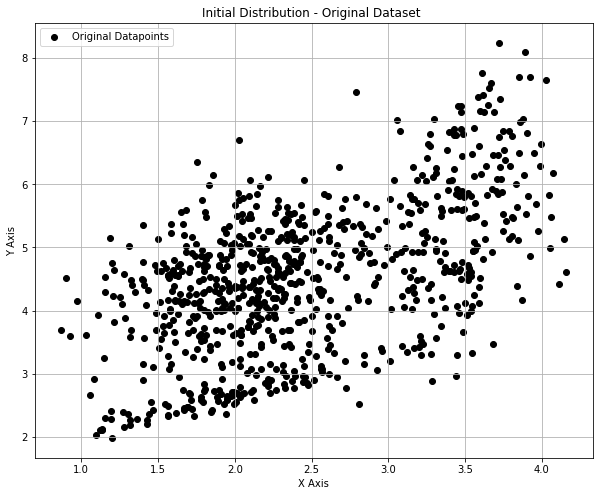

In [4]:
def plot_original_dataset(data):
    plt.figure(figsize=(10,8))
    plt.scatter(data[:,0],data[:,1],color='black',label='Original Datapoints')
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.title("Initial Distribution - Original Dataset ")
    plt.legend()
    plt.grid()
    plt.show()
    
#Plot original dataset - 1
plot_original_dataset(data)

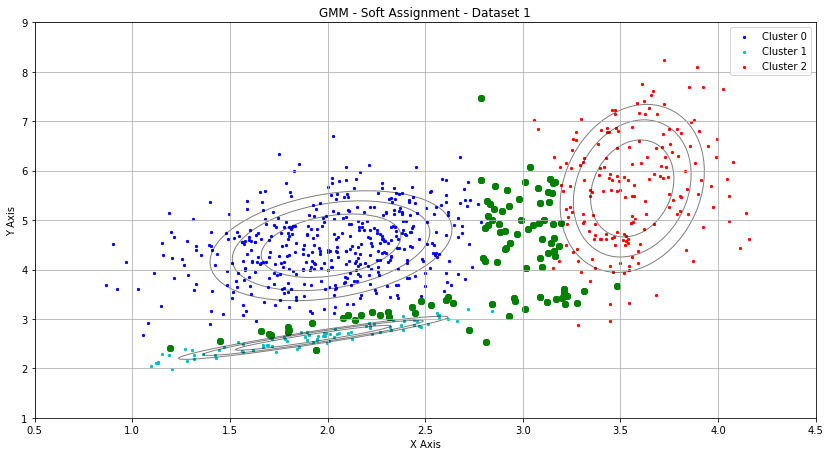

In [5]:
#Helper function to plot ellipsoids using PCA
def plotEllipsoids(mean, covariance, color,splot,std):
    v, w = np.linalg.eigh(covariance)
    v = 1.8 * np.sqrt(std) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle=np.arctan2(u[1], u[0])
    # convert angle into degrees
    angle = 180. * angle / np.pi  
    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180 + angle, color="black", fill=False)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
       
#EM algorithm implementation
def algorithmEM(gmm, X, out_X, index, soft=False):
    splot = plt.subplot(2, 1, 1 + index)
    colors = itertools.cycle(['b', 'c', 'red'])
    cluster_names = ["Cluster 0", "Cluster 1", "Cluster 2"]
    labels=gmm.predict(X)
    for i, (mean, covar, color, cluster) in enumerate(zip(gmm.means_, gmm.covariances_, colors, cluster_names)):
        if soft:
            plt.scatter(X[labels == i, 0], X[labels == i, 1], 5, color=color,label=cluster)
            #Plot outlier points
            plt.scatter(out_X[:,0],out_X[:,1],color='g')
        else:
            plt.scatter(X[labels == i, 0], X[labels == i, 1], 5, color=color,label=cluster)
        
        plotEllipsoids(mean, covar, color,splot,1)
        plotEllipsoids(mean, covar, color,splot,2)
        plotEllipsoids(mean, covar, color,splot,3)
        
    plt.xlim(0.5, 4.5)
    plt.ylim(1, 9)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.grid()
    plt.legend()

#Helper function to find out outliers using their probabilities.
def extract_outliers(gmm,X):
    gmm_fit=gmm.fit(X)
    prediction_probabilities = gmm_fit.predict_proba(X)
    prediction_probabilities_greater_ninety=np.where(prediction_probabilities > 0.9)
    indices_prediction_probabilities_greater_ninety=np.array(prediction_probabilities_greater_ninety[0])
    X_no_outliers=data[indices_prediction_probabilities_greater_ninety]
    prediction_probabilities_lesser_ninety=np.where(np.all(prediction_probabilities < 0.9,axis=1))
    indices_prediction_probabilities_lesser_ninety=np.array(prediction_probabilities_lesser_ninety[0])
    outliers_X=data[indices_prediction_probabilities_lesser_ninety]
    return X_no_outliers, outliers_X
        
    
#Wrapper method for GMM model w.r. to hard and soft assignments.
def init_gmm(gmm_data,X,soft=False):
    #For soft assignment
    if soft:
        data, outliers_data= extract_outliers(gmm_data,X)
        gmm_soft = mixture.GaussianMixture(n_components=3, covariance_type='full',max_iter=100, init_params='kmeans').fit(data)
        return gmm_soft, data, outliers_data
    
    #For hard assignment
    else:
        return gmm_data.fit(X), X, None
    
if __name__ == '__main__':
    gmm_obj = mixture.GaussianMixture(n_components=3, covariance_type='full',max_iter=100, init_params='kmeans')
    gmm_1,data_1,outliers_1=init_gmm(gmm_obj,data,True)
    algorithmEM(gmm_1,data_1,outliers_1,0,True)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(14,16)
    plt.title("GMM - Soft Assignment - Dataset 1")
    plt.show()

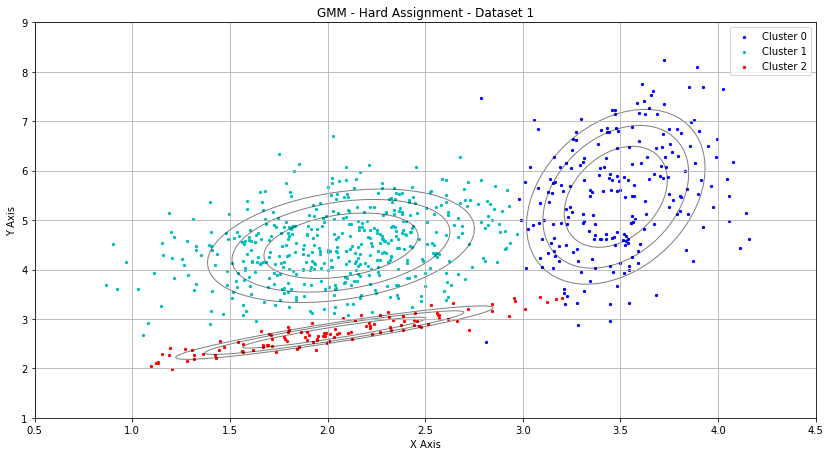

In [6]:
#Hard Assignment
gmm_hard_1,data_hard_1,outliers_hard_1=init_gmm(gmm_obj,data,False)
algorithmEM(gmm_hard_1,data_hard_1,outliers_hard_1,0,False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14,16)
plt.title("GMM - Hard Assignment - Dataset 1")
plt.show()

#### Explain the concept behind your ellipsoid plotting, like how you plotted it

1. Ellipsoid is plotted using **principal componenet analysis** approach. The plotting is facilitated by **matplotlib.patches.Ellipse()**. <br>
2. The mean and covariance are taken from the GMM model after fitting our data. <br>
3. In order to plot the ellipse, the size and orientation is needed. <br>
4. To facilitate that, Eigen values and Eigen vectors are determined from the covariance matrix and it is sorted in the descending order where largest eigen value with its vector lies at first. <br>
5. The angle is determined using the eigen vectors that has largest eigen values. <br>
6. Finally, the ellipse is plotted using the determined parameters - **(x,y), width, height, angle** etc. for 3 standars deviations.



**References** <br> <br>
https://towardsdatascience.com/kmeans-hyper-parameters-explained-with-examples-c93505820cd3 <br>
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py